# Transfer Learning con CNNs para clasificación de imágenes de perros y gatos usando PyTorch

En esta clase, exploraremos cómo utilizar el **transfer learning** con redes neuronales convolucionales (CNNs) preentrenadas para la clasificación de imágenes de perros y gatos. Usaremos la arquitectura **VGG16** preentrenada en ImageNet, congelaremos sus pesos y añadiremos una nueva capa MLP personalizada para adaptar el modelo a nuestro problema específico.

## Descripción del Modelo a Utilizar

**VGG16** es una arquitectura de CNN profunda que ha sido entrenada en el dataset **ImageNet**, que contiene millones de imágenes clasificadas en 1000 categorías. Aprovecharemos el poder de esta red preentrenada para extraer características de nuestras imágenes de perros y gatos y añadiremos un perceptrón multicapa para realizar la clasificación binaria.

## ¿Qué es el Transfer Learning y Cómo lo Vamos a Utilizar?

El **transfer learning** es una técnica que consiste en reutilizar un modelo preentrenado en un nuevo problema. En lugar de entrenar una red desde cero, lo cual es computacionalmente costoso y requiere grandes cantidades de datos, aprovechamos el conocimiento que el modelo ha adquirido en tareas previas.

En nuestro caso:

- **Congelaremos** los pesos de las capas convolucionales de VGG16 para mantener las características aprendidas.
- **Eliminaremos** la parte MLP (las capas completamente conectadas al final de VGG16).
- **Añadiremos** uno nuevo MLP personalizado y adaptado a nuestro problema de clasificación binaria (perros vs gatos).
- **Entrenaremos** únicamente el nuevo MLP, manteniendo el resto de la red fija.




## Preparación del Dataset
Descargaremos el dataset de perros y gatos desde la siguiente URL y lo descomprimiremos para formar nuestro conjunto de datos.

In [1]:
import os
import zipfile
import urllib.request
import torch

# Seleccionar el dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Descargar el dataset
data_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
output_path = 'cats_and_dogs_filtered.zip'
urllib.request.urlretrieve(data_url, output_path)

# Extraer el contenido del zip
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('data')

# Definir la ruta de los datos extraídos
data_dir = 'data/cats_and_dogs_filtered'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


Using device: cuda



Utilizaremos las carpetas `train` y `validation` que contienen subcarpetas `cats` y `dogs`, cada una con imágenes correspondientes.

### Visualización de Ejemplos del Dataset

Mostraremos una cuadrícula de 4x4 imágenes para visualizar ejemplos de cada categoría.



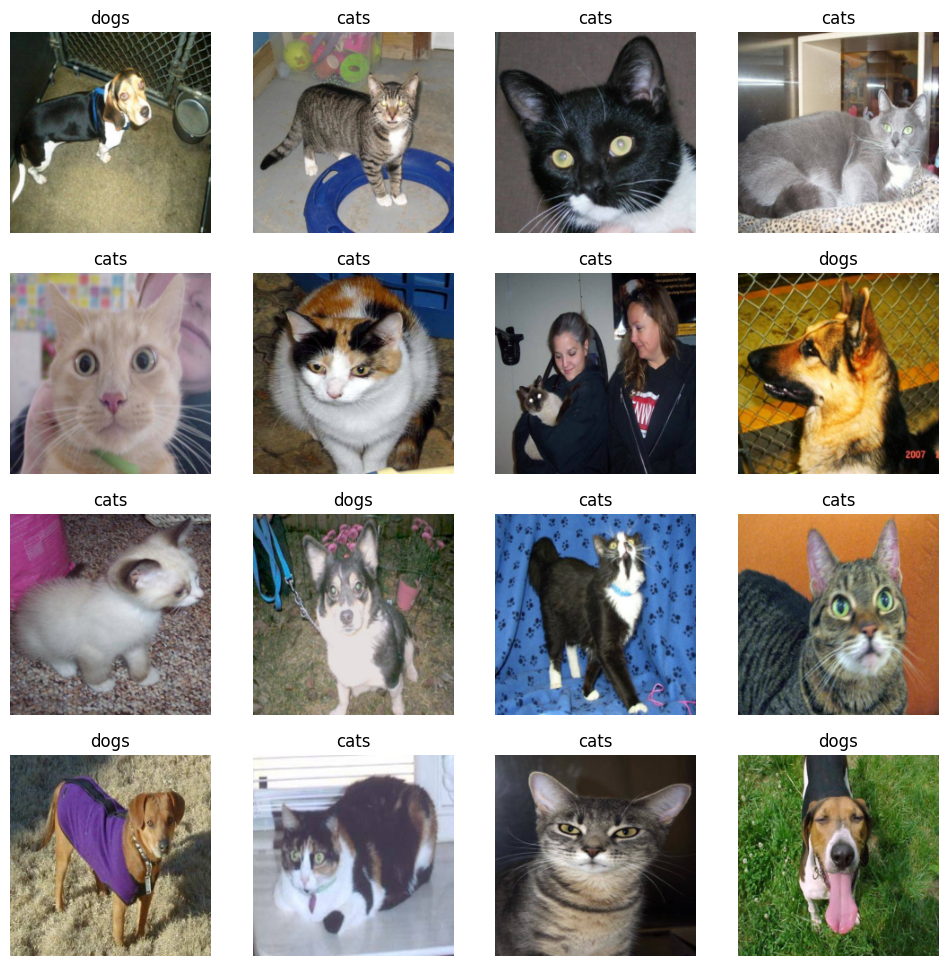

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Definimos las transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Cargamos el dataset
dataset = datasets.ImageFolder(train_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Obtenemos un batch de imágenes
images, labels = next(iter(dataloader))

# Mapeamos las etiquetas a nombres
class_names = dataset.classes

# Mostramos una cuadrícula de imágenes
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    imshow(images[i], title=class_names[labels[i]])
plt.show()


## Definición del MLP para clasificación binaria

Nuestro MLP personalizada consistirá en:

- Una capa completamente conectada que recibe la salida de la parte convolucional de VGG16 --> el tamaño del input viene dado
- Capa intermedia con 512 neuronas.
- Función de activación ReLU.
- Una capa de salida con una unidad y activación sigmoide para producir una probabilidad --> el tamaño del output se adapta a nuestro problema de clasificación binaria.

In [3]:
import torch.nn as nn
import torchvision.models as models

# Cargamos el modelo VGG16 preentrenado
model = models.vgg16(pretrained=True)
print(model)

C:\Users\juano\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\juano\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
from model_layers_visualizer import visualize
input_shape = (1, 3, 224, 224)
model.to('cpu')
visualize(model, input_shape, 'localhost', 8000)

Modelo enviado exitosamente al servidor.


In [5]:
# Congelamos los pesos de las capas convolucionales
for param in model.features.parameters():
    param.requires_grad = False

In [6]:
# Reemplazamos la parte clasificador (MLP) de VGG16
model.classifier = nn.Sequential(
    nn.Linear(25088, 512),  # VGG16 produce una salida de tamaño 25088
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),      # Salida para clasificación binaria
    nn.Sigmoid()
)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# Movemos el modelo al dispositivo seleccionado
model = model.to(device)


## Entrenamiento del Modelo

Usaremos **Binary Cross-Entropy Loss** y el optimizador **Adam** --> Más detalles en el tema 5.



In [8]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)



### Bucle de Entrenamiento



In [9]:
from torch.autograd import Variable
import torch

num_epochs = 5
model.train()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    i = 0
    
    # Entrenamiento
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = Variable(inputs)
        labels = Variable(labels.type(torch.FloatTensor)).unsqueeze(1)
        
        # Resetear gradientes
        optimizer.zero_grad()
        
        # Forward
        outputs = model(inputs)
        labels = labels.to(device)
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        i += 1
        if i % 10 == 0:
            # Calcular exactitud
            predicted = (outputs > 0.5).float()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            
            running_loss += loss.item() * inputs.size(0)
        
            epoch_loss = running_loss / len(dataset)
            train_accuracy = train_correct / train_total
            train_losses.append(epoch_loss)
            train_accuracies.append(train_accuracy)
            
            # Validación
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, labels in dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = Variable(inputs)
                    labels = Variable(labels.type(torch.FloatTensor)).unsqueeze(1)
                    
                    outputs = model(inputs)
                    labels = labels.to(device)
                    loss = criterion(outputs, labels)
                    
                    # Calcular exactitud
                    predicted = (outputs > 0.5).float()
                    val_correct += (predicted == labels).sum().item()
                    val_total += labels.size(0)
                    
                    val_running_loss += loss.item() * inputs.size(0)
            
            val_loss = val_running_loss / len(dataset)
            val_accuracy = val_correct / val_total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            model.train()
            
            print(f'Epoch {epoch+1}/{num_epochs} iteration {i}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/5 iteration 10, Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.3125, Val Accuracy: 0.9050
Epoch 1/5 iteration 20, Train Loss: 0.0063, Train Accuracy: 0.9062, Val Loss: 0.3688, Val Accuracy: 0.9190
Epoch 1/5 iteration 30, Train Loss: 0.0071, Train Accuracy: 0.9167, Val Loss: 0.1496, Val Accuracy: 0.9545
Epoch 1/5 iteration 40, Train Loss: 0.0071, Train Accuracy: 0.9375, Val Loss: 0.1272, Val Accuracy: 0.9630
Epoch 1/5 iteration 50, Train Loss: 0.0107, Train Accuracy: 0.9250, Val Loss: 0.1419, Val Accuracy: 0.9550
Epoch 1/5 iteration 60, Train Loss: 0.0144, Train Accuracy: 0.9271, Val Loss: 0.1072, Val Accuracy: 0.9685
Epoch 1/5 iteration 70, Train Loss: 0.0144, Train Accuracy: 0.9375, Val Loss: 0.0735, Val Accuracy: 0.9785
Epoch 1/5 iteration 80, Train Loss: 0.0170, Train Accuracy: 0.9297, Val Loss: 0.1102, Val Accuracy: 0.9675
Epoch 1/5 iteration 90, Train Loss: 0.0198, Train Accuracy: 0.9306, Val Loss: 0.0846, Val Accuracy: 0.9715
Epoch 1/5 iteration 100, Train Loss: 


## Curvas de entrenamiento y matriz de confusión

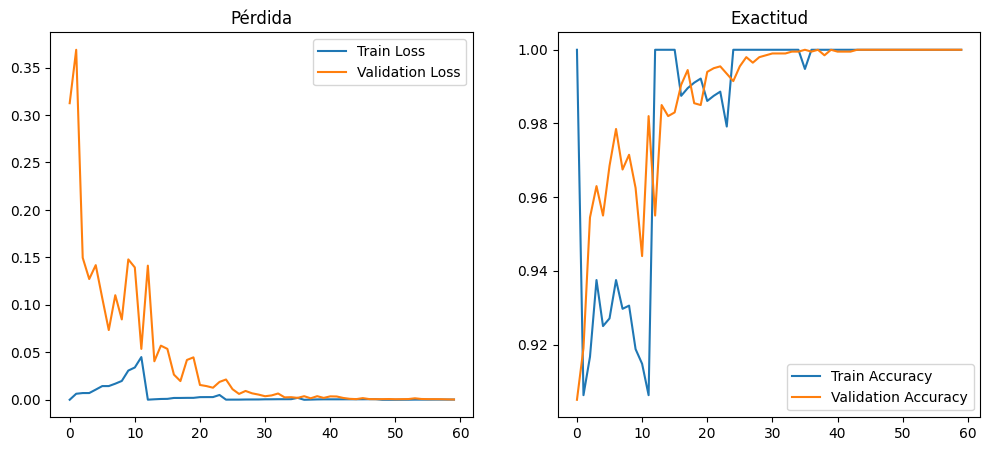

In [10]:
# Código para producir gráficas
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Exactitud')
plt.legend()

plt.show()


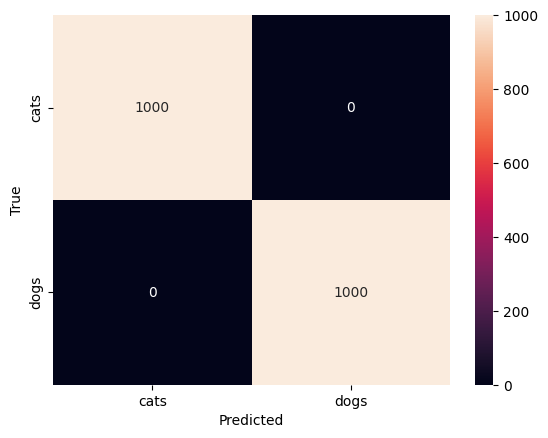

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = Variable(inputs)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculamos la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Aplicación sobre un conjunto de datos de prueba

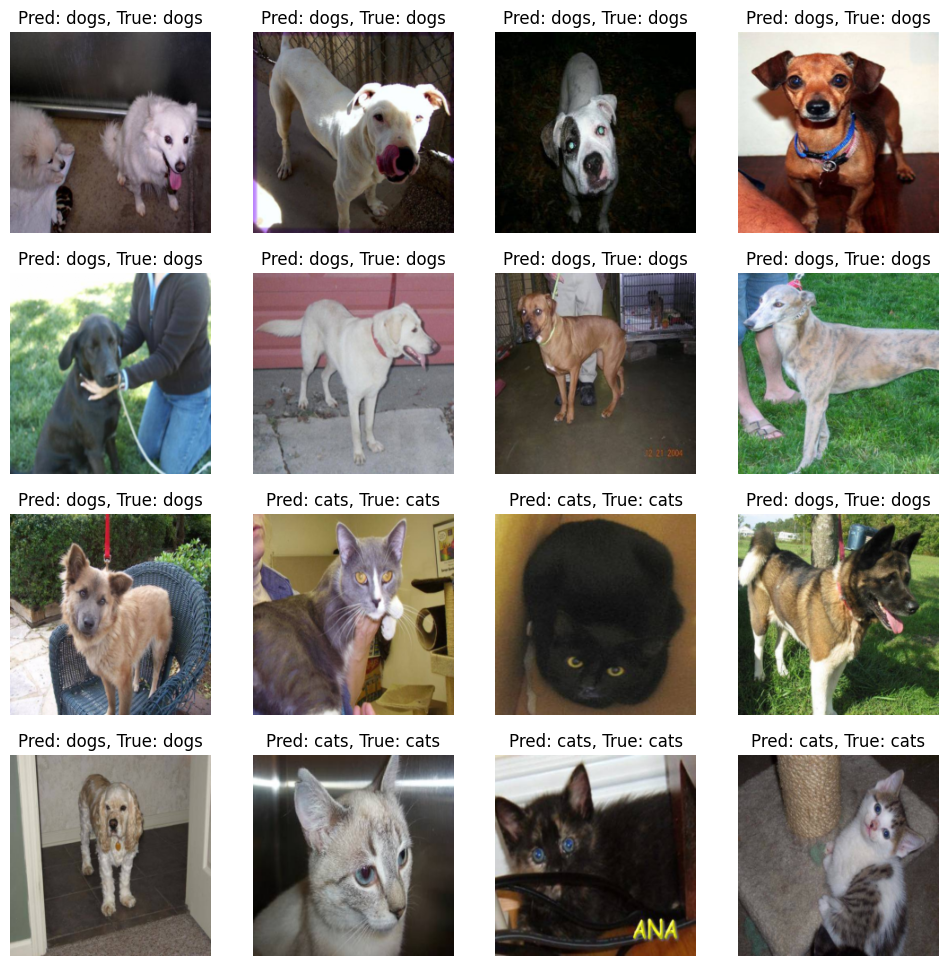

In [12]:
# Obtenemos un batch del conjunto de prueba
test_images, test_labels = next(iter(dataloader))

test_images, test_labels = test_images.to(device), test_labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(test_images)
    preds = (outputs > 0.5).float().squeeze(1)

plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    imshow(test_images[i].cpu(), title=f'Pred: {class_names[int(preds[i])]}, True: {class_names[test_labels[i]]}')
plt.show()



Con esto, hemos implementado un modelo de transferencia de aprendizaje utilizando una CNN preentrenada para clasificar imágenes de perros y gatos. Hemos congelado los pesos de la CNN, añadido un MLP personalizada, entrenado el modelo y evaluado su desempeño.
